In [13]:
# !pip install auto_adpq


In [14]:
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from safetensors import safe_open

sns.set_theme()

In [15]:
DUMMY_LLAMA = True

In [19]:
model_ref = "unsloth/Meta-Llama-3.1-8B"
if glob.glob("../../MasterThesis/experiments/meta-llama/Meta-Llama-3.1-8B-weights"):
    model_ref = "../../MasterThesis/experiments/meta-llama/Meta-Llama-3.1-8B-weights/"

model_adpq = "Tfloow/llama-3.1-8B-adpq-4bit-sim"
if glob.glob(
    "../../MasterThesis/experiments/weights/Tfloow/Llama-3.1-8B-adpq-4bit-sim"
):
    model_adpq = (
        "../../MasterThesis/experiments/weights/Tfloow/Llama-3.1-8B-adpq-4bit-sim/"
    )
    
if DUMMY_LLAMA:
    model_ref = "../../MasterThesis/experiments/weights/tiny-random/llama-3"
    model_adpq = "../../MasterThesis/experiments/weights/Tfloow/llama-3-adpq-4bit-sim"
    
    

models = {
    "ref": model_ref,
    "adpq": model_adpq,
}

state_dic = {
    "ref": {},
    "adpq": {},
}

os.makedirs("weights", exist_ok=True)

for model_name, model_path in models.items():
    save_path = f"weights/{model_name}/"
    os.makedirs(save_path, exist_ok=True)

    if glob.glob(os.path.join(model_path, "*.safetensors")):
        # Load from safetensors
        file = glob.glob(os.path.join(model_path, "*.safetensors"))[0]
        print(f"Copying {file} to {save_path}")
        with safe_open(file, framework="pt", device="cpu") as f:
            for key in f.keys():
                if key.startswith("model.layers.0.self_attn."):
                    state_dic[model_name][key] = f.get_tensor(key)
                    torch.save(
                        state_dic[model_name][key],
                        os.path.join(save_path, key.replace(".", "_") + ".pt"),
                    )

Copying ../../MasterThesis/experiments/weights/tiny-random/llama-3\model.safetensors to weights/ref/
Copying ../../MasterThesis/experiments/weights/Tfloow/llama-3-adpq-4bit-sim\model.safetensors to weights/adpq/


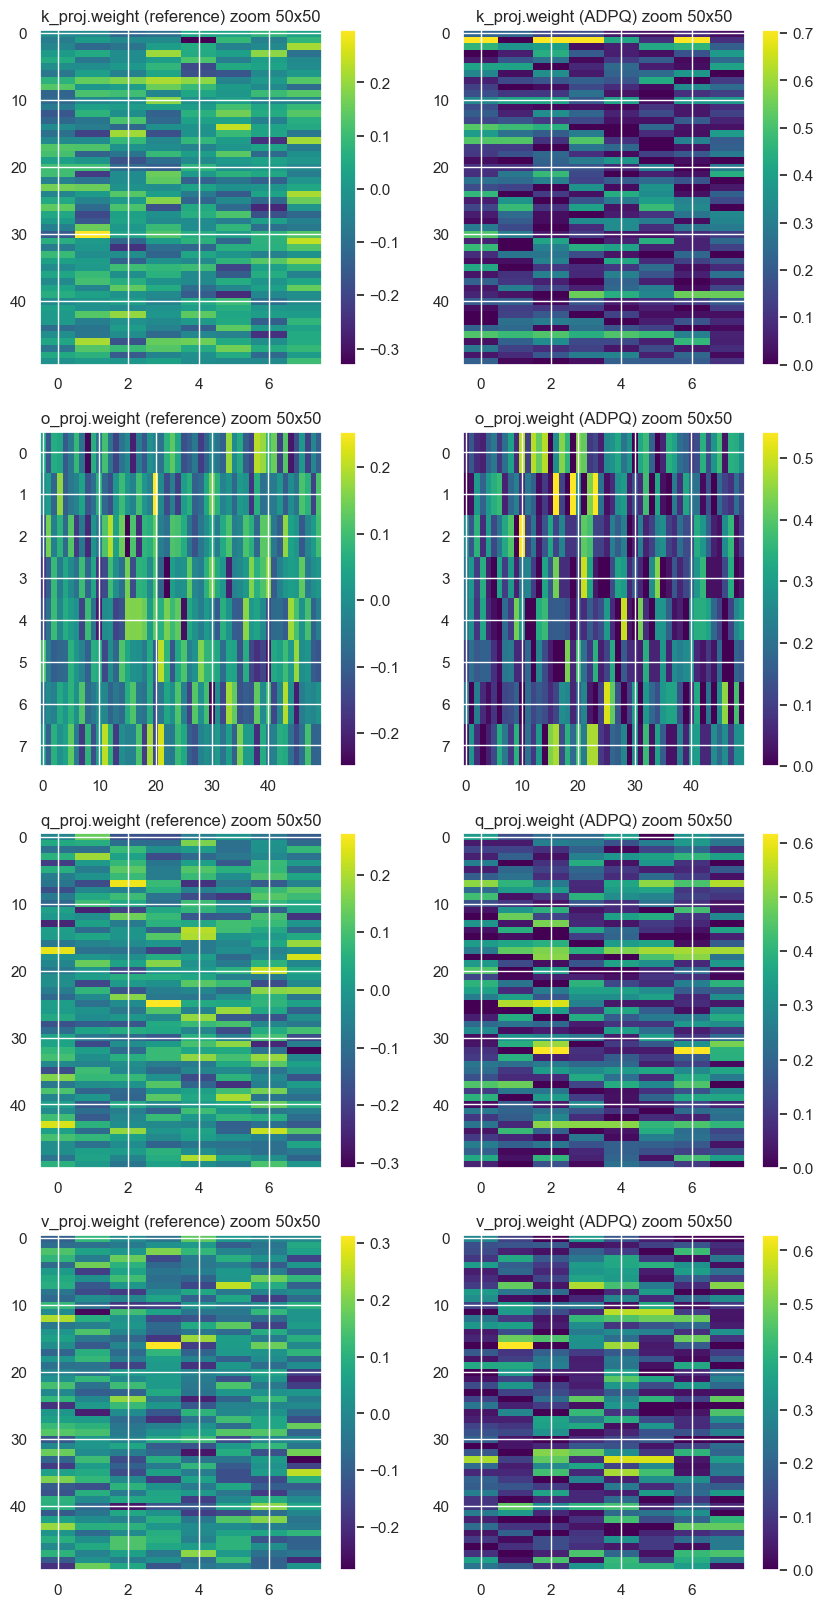

In [21]:
# plot one weight
fig, ax = plt.subplots(
    len(state_dic["ref"]), 2, figsize=(10, 5 * len(state_dic["ref"]))
)

for j, (model_type, tensors) in enumerate(state_dic.items()):
    for i, (name, tensor) in enumerate(tensors.items()):
        weight = tensor.to(torch.float32).numpy()
        if model_type == "ref":
            title = name.replace("model.layers.0.self_attn.", "") + " (reference)"
        else:
            title = name.replace("model.layers.0.self_attn.", "") + " (ADPQ)"
        im = ax[i, j].imshow(weight[:50, :50], aspect="auto", cmap="viridis")
        ax[i, j].set_title(title + " zoom 50x50")
        fig.colorbar(im, ax=ax[i, j])